**1. Import Libraries/ Dataset**

a. Import the required libraries and the dataset (use Google Drive if required).

b. Check the GPU available (recommended- use free GPU provided by Google Colab).

In [30]:
import os
import tarfile

import keras_preprocessing
from keras_preprocessing import image
from keras_preprocessing.image import ImageDataGenerator
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras import regularizers
from timeit import default_timer as timer

from sklearn.metrics import classification_report, confusion_matrix
import itertools

print(tf.__version__)

2.4.1


In [31]:
# copy dataset
!wget --no-check-certificate \
  https://s3.amazonaws.com/fast-ai-imageclas/imagenette2-160.tgz \
  -O /tmp/imagenette2-160.tgz

--2021-05-23 13:19:51--  https://s3.amazonaws.com/fast-ai-imageclas/imagenette2-160.tgz
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.160.189
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.160.189|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 99003388 (94M) [application/x-tar]
Saving to: ‘/tmp/imagenette2-160.tgz’

/tmp/imagenette2-16 100%[===================>]  94.42M   105MB/s    in 0.9s    

2021-05-23 13:19:52 (105 MB/s) - ‘/tmp/imagenette2-160.tgz’ saved [99003388/99003388]



In [32]:
# open file
file = tarfile.open('/tmp/imagenette2-160.tgz')
  
# extract file
file.extractall('/tmp')

#close file
file.close()

In [33]:
# set directories
base_dir = '/tmp/imagenette2-160'
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')

**2. Data Visualization and Augmentation**

a. Plot at least two samples from each class of the dataset (use matplotlib/seaborn/any other library).

b. Apply rotation and height shift augmentation (rotation_range, height_shift_range) to the dataset separately. Print the augmented image and the original image for each class and each augmentation.

c. Bring the train and test data in the required format.

d. Print the shapes of train and test data.



In [34]:
# set image and batch size
num_img_rows=75 # image height, actual=213
num_img_cols=75 # image width, actual=160
num_color_channels=3
num_batch_size=100

train_datagen = ImageDataGenerator(
                  rescale=1.0/255.0,
                  rotation_range=40,
                  height_shift_range=0.2,
                  fill_mode='nearest'
                )

val_datagen = ImageDataGenerator(
                rescale=1.0/255.0
              )

train_generator = train_datagen.flow_from_directory(
                    train_dir,
                    batch_size=num_batch_size,
                    target_size=(num_img_rows, num_img_cols),
                    class_mode='categorical'
                  )

val_generator = val_datagen.flow_from_directory(
                  val_dir,
                  batch_size=num_batch_size,
                  target_size=(num_img_rows, num_img_cols),
                  class_mode='categorical'
                )

# print shape of training data after transformation
for train_image_batch, train_labels_batch in train_generator:
  print('Training image batch shape, after transformation:', train_image_batch.shape)
  print('Training label batch shape, after transformation:', train_labels_batch.shape)
  break

# print shape of test data after transformation
for val_image_batch, val_labels_batch in val_generator:
  print('Validation image batch shape, after transformation:', val_image_batch.shape)
  print('Validation label batch shape, after transformation:', val_labels_batch.shape)
  break

Found 9469 images belonging to 10 classes.
Found 3925 images belonging to 10 classes.
Training image batch shape, after transformation: (100, 75, 75, 3)
Training label batch shape, after transformation: (100, 10)
Validation image batch shape, after transformation: (100, 75, 75, 3)
Validation label batch shape, after transformation: (100, 10)


In [35]:
# Preparing ImageDataGenerator for augmentation

train_datagen_rotate = ImageDataGenerator(rescale=1/255, rotation_range=30, fill_mode='nearest')
train_datagen_hshift = ImageDataGenerator(rescale=1/255, height_shift_range=0.3)

hshift_train_dir = '/tmp/imagenette2-160/train_hshift'
rotate_train_dir = '/tmp/imagenette2-160/train_rotate'

## Data Augumentation... 
def apply_augmentation(train_dir, tgt_dir, img_datagen):
  print ('\n', "Applying Augmentation to Target directory :", tgt_dir)
  for i, folder_name in enumerate(os.listdir(train_dir)):
    if (folder_name != '.DS_Store'):
      hshift_folder_name = '/tmp/imagenette2-160/' + tgt_dir +'/' + folder_name
      if (os.path.exists(hshift_folder_name) == False):
        os.makedirs(hshift_folder_name)

      img_placeholder = []
      folder_name = '/tmp/imagenette2-160/train/' + folder_name + '/'
      folder_images = os.listdir(folder_name)
      print ("Processing folder: ", folder_name)

      for j, img_name in enumerate(folder_images):
        tmp_image = image.load_img(folder_name + img_name)
        x = image.img_to_array(tmp_image)  # this is a Numpy array with shape (160, 160, 3)    
        x = x.reshape((1,) + x.shape)  # this is a Numpy array with shape (1, 160, 160, 3)
        # train_datagen_hflip.flow(x, batch_size=512,save_to_dir= hshift_folder_name, save_prefix=img_name,save_format="jpeg")
        k = 0
        for batch in img_datagen.flow(x, batch_size=512,save_to_dir= hshift_folder_name, save_prefix=img_name,save_format="jpeg"):
          k += 1
          # print ("in flow func | folder_name", img_name, folder_name)
          if k > 0:
            break  # otherwise the generator would loop indefinitely
      
      aug_folder_images = os.listdir(hshift_folder_name + '/')
      for k, aug_img_name in enumerate(aug_folder_images):
          new_img_name = aug_img_name.split('.')[0]
          new_img_name = new_img_name + '.jpeg'
          src = hshift_folder_name + '/' + aug_img_name
          dst = hshift_folder_name + '/' + new_img_name
          os.rename(src,dst)

def get_pics_list(train_dir, num_imgs):
  print ("Getting pictures list...")
  pic = {}
  pic_names_list = {}
  for dir in os.listdir(train_dir):
    if (dir != ".DS_Store"):
      print("processing dir :", dir)
      i = 0
      for fname in os.listdir(os.path.join(train_dir,dir)): 
        if (i < num_imgs):
          # print("processing file :", i, ":", fname)
          # pic.append(os.path.join(train_dir,dir,fname))
          pic[dir + '_'+str(i)] = os.path.join(train_dir,dir,fname)
          pic_names_list[dir + '_'+str(i)] = fname
        i += 1
  return pic_names_list 
def print_sample_imgs(pic):
  nrows = 20
  ncols = 3

  # Index for iterating over images
  pic_index = 0
  # Set up matplotlib fig, and size it to fit 4x4 pics
  fig = plt.gcf()
  fig.set_size_inches(ncols * 6, nrows * 3)

  print("======================================================")
  print("Printing Sample image with Height shift and Rotation :")
  print("======================================================")
  j = 0
  for i, img_nm in enumerate(pic.keys()):
    just_img_nm = img_nm.split(sep='_')[0]
    # Set up subplot; subplot indices start at 1
    sp = plt.subplot(nrows, ncols, j + 1)
    sp.axis('Off') # Don't show axes (or gridlines)
    sp.set_title(just_img_nm)
    # printing main img
    raw_img_nm = train_dir + '/' + just_img_nm + '/' + pic[img_nm]
    img = mpimg.imread(raw_img_nm)
    # print (raw_img_nm)
    plt.imshow(img)

    sp = plt.subplot(nrows, ncols, j + 2)
    sp.axis('Off') # Don't show axes (or gridlines)
    sp.set_title(just_img_nm + '(Height_Shift)')
    hshift_img_nm = hshift_train_dir + '/' + just_img_nm + '/' + pic[img_nm].split(sep='.')[0] + '.jpeg'
    aug_img = mpimg.imread(hshift_img_nm)
    # print (hshift_img_nm)
    plt.imshow(aug_img)
    
    sp = plt.subplot(nrows, ncols, j + 3)
    sp.axis('Off') # Don't show axes (or gridlines)
    sp.set_title(just_img_nm + '(Rotation)')
    rot_img_nm = rotate_train_dir + '/' + just_img_nm + '/' + pic[img_nm].split(sep='.')[0] + '.jpeg'
    rot_img = mpimg.imread(rot_img_nm)
    # print (rot_img_nm)
    plt.imshow(rot_img)
    
    
    j = j + 3
  plt.show()
  # plt.show()

In [36]:
pics_list = get_pics_list('/tmp/imagenette2-160/train/', 2)

Getting pictures list...
processing dir : n03028079
processing dir : n01440764
processing dir : n03445777
processing dir : n03888257
processing dir : n03417042
processing dir : n03425413
processing dir : n02102040
processing dir : n03000684
processing dir : n03394916
processing dir : n02979186


Printing Sample (2) images from each Label :


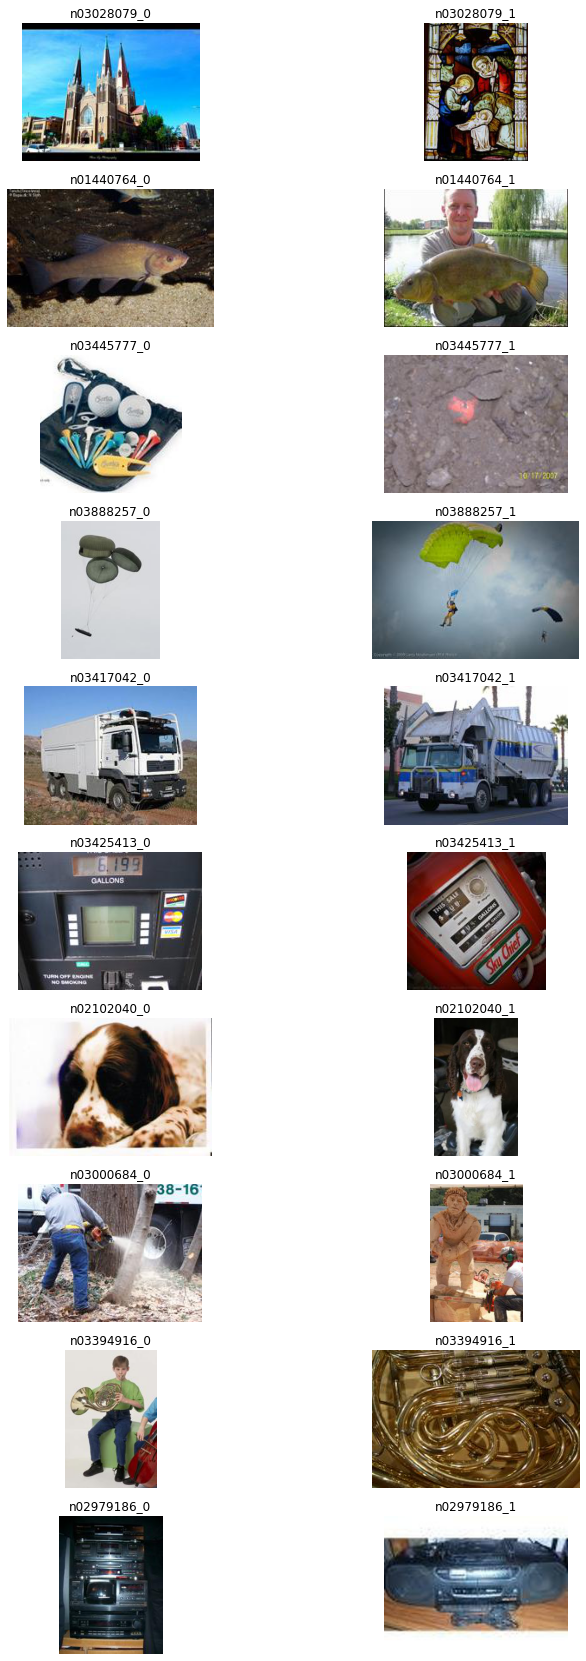

In [37]:
# Printing sample images from each target class

# Parameters for our graph; we'll output images in a 4x4 configuration
nrows = 10
ncols = 2
  # Index for iterating over images
pic_index = 0 
# Set up matplotlib fig, and size it to fit 4x4 pics
fig = plt.gcf()
fig.set_size_inches(ncols * 6, nrows * 3)

print("============================================")
print("Printing Sample (2) images from each Label :")
print("============================================")
for i, img_path in enumerate(pics_list.keys()):
  just_img_nm = img_path.split(sep='_')[0]
  # Set up subplot; subplot indices start at 1
  sp = plt.subplot(nrows, ncols, i + 1)
  sp.axis('Off') # Don't show axes (or gridlines)
  sp.set_title(img_path)
  raw_img_nm = train_dir + '/' + just_img_nm + '/' + pics_list[img_path]
  img = mpimg.imread(raw_img_nm)
  plt.imshow(img)

plt.show()

Getting pictures list...
processing dir : n03028079
processing dir : n01440764
processing dir : n03445777
processing dir : n03888257
processing dir : n03417042
processing dir : n03425413
processing dir : n02102040
processing dir : n03000684
processing dir : n03394916
processing dir : n02979186
Applying Augmentation to Target directory : train_hshift
Processing folder:  /tmp/imagenette2-160/train/n03028079/
Processing folder:  /tmp/imagenette2-160/train/n01440764/
Processing folder:  /tmp/imagenette2-160/train/n03445777/
Processing folder:  /tmp/imagenette2-160/train/n03888257/
Processing folder:  /tmp/imagenette2-160/train/n03417042/
Processing folder:  /tmp/imagenette2-160/train/n03425413/
Processing folder:  /tmp/imagenette2-160/train/n02102040/
Processing folder:  /tmp/imagenette2-160/train/n03000684/
Processing folder:  /tmp/imagenette2-160/train/n03394916/
Processing folder:  /tmp/imagenette2-160/train/n02979186/
Applying Augmentation to Target directory : train_rotate
Processing 

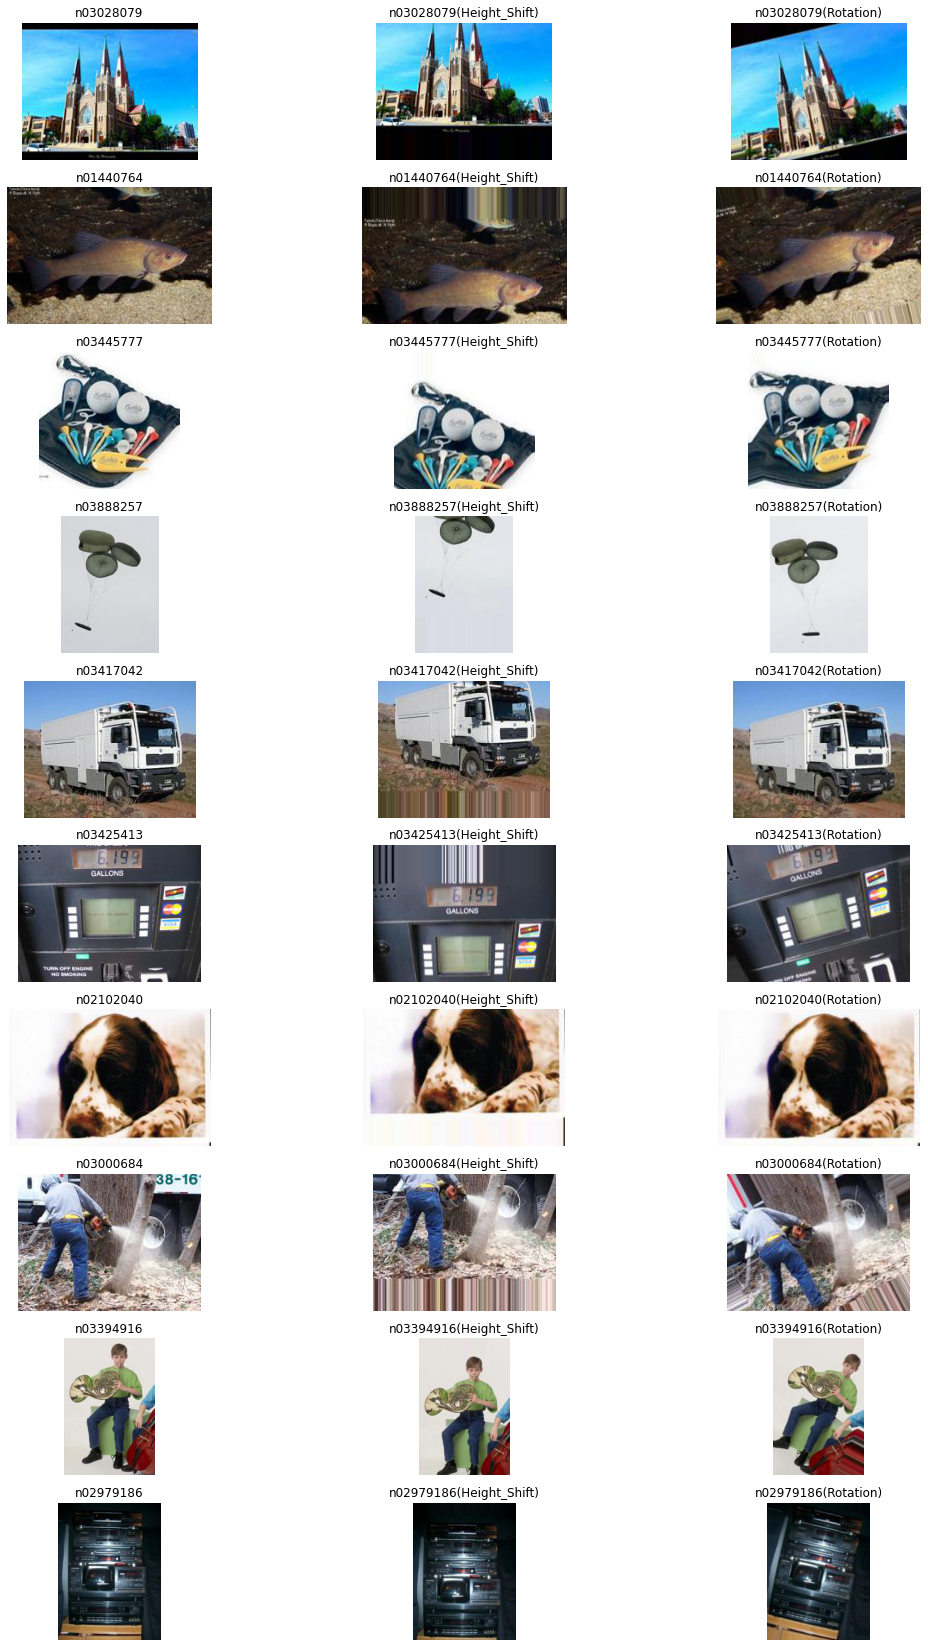

In [38]:
# Printing Augmented images

pics_list = get_pics_list('/tmp/imagenette2-160/train/', 1)

#Applying Augmentation
apply_augmentation(train_dir, "train_hshift", train_datagen_hshift)
apply_augmentation(train_dir, "train_rotate", train_datagen_rotate)

#printing Augmented images
print_sample_imgs(pics_list)

**3. Model Building**

a. Sequential Model layers- Use AT LEAST 3 hidden layers with appropriate input for each. Choose the best number for hidden units and give reasons.

b. Add L2 regularization to all the layers.

c. Add one layer of dropout at the appropriate position and give reasons.

d. Choose the appropriate activation function for all the layers.

e. Print the model summary.

In [39]:
# set model parameters
num_epochs=50
num_steps_per_epoch=95 # total training images/ batch size = 9465/100
num_val_steps=40 # total validation images/ batch size = 3925/100
num_dropout=0.2
num_l2_reg_penalty=0.0001
num_lr=1e-4
opt = RMSprop(lr=num_lr)
str_loss = 'categorical_crossentropy'

# build model
model = tf.keras.models.Sequential([
          # Flatten input
          tf.keras.layers.Flatten(input_shape=(num_img_rows,num_img_cols, num_color_channels)),
          # Layer 1 = input layer with regularization
          tf.keras.layers.Dense(1024, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(num_l2_reg_penalty)),
          # Add dropout
          tf.keras.layers.Dropout(num_dropout),
          # Layer 2 = hidden layer with regularization
          tf.keras.layers.Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(num_l2_reg_penalty)),
          # Layer 3 = hidden layer with regularization
          tf.keras.layers.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(num_l2_reg_penalty)),
          # Layer 4 = hidden layer with regularization
          tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(num_l2_reg_penalty)),
          # Layer 5 = output layer with regularization
          tf.keras.layers.Dense(10, activation='softmax', kernel_regularizer=tf.keras.regularizers.l2(num_l2_reg_penalty)),
        ])

**4. Model Compilation**

a. Compile the model with the appropriate loss function.

b. Use an appropriate optimizer. Give reasons for the choice of learning rate and its value.

c. Use accuracy as a metric.

**To be done:**

Give reasons for the choice of learning rate and its value. 


In [40]:
# compile model
model.compile(loss=str_loss,
              optimizer=opt,
              metrics=['accuracy']
             )

**5. Model Training**

a. Train the model for an appropriate number of epochs. Print the train and validation accuracy and loss for each epoch. Use the appropriate batch size.

b. Plot the loss and accuracy history graphs for both train and validation set. Print the total time taken for training.

In [41]:
# timing callback class
class TimingCallback(keras.callbacks.Callback):
    def __init__(self, logs={}):
        self.logs=[]
    def on_epoch_begin(self, epoch, logs={}):
        self.starttime = timer()
    def on_epoch_end(self, epoch, logs={}):
        self.logs.append(timer()-self.starttime)

# timing callback
timing = TimingCallback()

# train model
history = model.fit(
            train_generator,
            epochs=num_epochs,
            steps_per_epoch=num_steps_per_epoch,
            validation_data=val_generator,
            validation_steps=num_val_steps,
            verbose=1,
            callbacks=[timing]
          )

# show model summary
model.summary()

# total training time
print('\n', 'Total time taken for training: {:.2f}'.format(sum(timing.logs)), 'seconds', '\n')

# save model
#model.save("vision.h5")

95/95 [==============================] - 21s 219ms/step - loss: 2.7414 - accuracy: 0.1419 - val_loss: 2.4602 - val_accuracy: 0.2201
Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_9 (Flatten)          (None, 16875)             0         
_________________________________________________________________
dense_49 (Dense)             (None, 1024)              17281024  
_________________________________________________________________
dropout_7 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_50 (Dense)             (None, 512)               524800    
_________________________________________________________________
dense_51 (Dense)             (None, 256)               131328    
_________________________________________________________________
dense_52 (Dense)             (None, 128)              

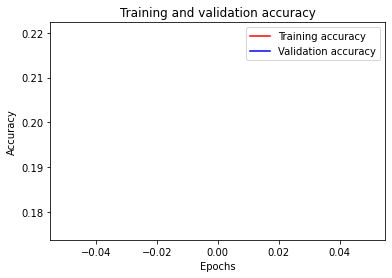

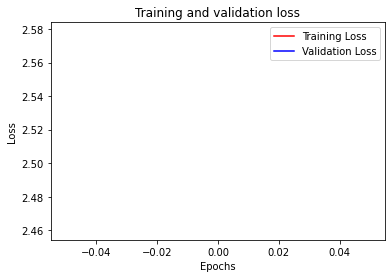

<Figure size 432x288 with 0 Axes>

In [42]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

# Accuracy history graph for training and validation
plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(loc=0)
plt.figure()

# Loss history graph for training and validation
plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(loc=0)
plt.figure()

# show plot
plt.show()

**6. Model Evaluation**

a. Print the final train and validation loss and accuracy. Print confusion matrix and classification report for the validation dataset. Analyse and report the best and worst performing class.

b. Print the two most incorrectly classified images for each class in the test dataset.

**To be done:**

Analyse and report the best and worst performing class.

Print the two most incorrectly classified images for each class in the test dataset.


In [43]:
# final training accuracy and loss
print('\n')
train_score = model.evaluate(train_generator)

print("Training accuracy: {:.2f}%".format(train_score[1] * 100)) 
print("Training Loss: ",train_score[0])

# final validation accuracy and loss
print('\n')
val_score = model.evaluate(val_generator)

print("Validation accuracy: {:.2f}%".format(val_score[1] * 100)) 
print("Validation Loss: ",val_score[0])



95/95 [==============================] - 17s 182ms/step - loss: 2.4896 - accuracy: 0.2009
Training accuracy: 20.09%
Training Loss:  2.4896080493927


40/40 [==============================] - 3s 76ms/step - loss: 2.4602 - accuracy: 0.2201
Validation accuracy: 22.01%
Validation Loss:  2.4601826667785645


In [44]:
# get target names
target_names = []
for key in train_generator.class_indices:
    target_names.append(key)

# print target_names
print('Target names:', target_names, '\n')

# Print Confusion Matrix 
Y_pred = model.predict(train_generator)
y_pred = np.argmax(Y_pred, axis=1)
cm = confusion_matrix(train_generator.classes, y_pred)
print('Confusion Matrix', '\n', cm, '\n')

# Print Classification Report
print('Classification Report')
print(classification_report(train_generator.classes, y_pred, target_names=target_names))

Target names: ['n01440764', 'n02102040', 'n02979186', 'n03000684', 'n03028079', 'n03394916', 'n03417042', 'n03425413', 'n03445777', 'n03888257'] 

Confusion Matrix 
 [[  0 537  56   5   8  71  20  17 217  32]
 [  0 530  67   1   6  68  18  19 217  29]
 [  0 585  64   3   3  66  22  16 209  25]
 [  0 475  53   9   5  65  15  14 193  29]
 [  0 504  78   3   6  66  17  10 232  25]
 [  0 555  79   5   7  72  24  16 164  34]
 [  0 519  86   7   3  69  13  19 206  39]
 [  0 522  70   2  11  65  15  14 210  22]
 [  0 523  61   8   3  64  18   9 233  32]
 [  0 557  74   3   7  68  13  16 193  29]] 

Classification Report
              precision    recall  f1-score   support

   n01440764       0.00      0.00      0.00       963
   n02102040       0.10      0.55      0.17       955
   n02979186       0.09      0.06      0.08       993
   n03000684       0.20      0.01      0.02       858
   n03028079       0.10      0.01      0.01       941
   n03394916       0.11      0.08      0.09       956


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


**Hyperparameter Tuning**

Build two more additional models by changing the following hyperparameters ONE at a time. Write the code for Model Building, Model Compilation, Model Training and Model Evaluation as given in the instructions above for each additional model.

1. Network Depth: Change the number of hidden layers and hidden units for each layer

2. Regularization: Train a model without regularization

Write a comparison between each model and give reasons for the difference in results.

**To be done:**

Write a comparison between each model and give reasons for the difference in results.

95/95 [==============================] - 21s 217ms/step - loss: 2.5433 - accuracy: 0.1406 - val_loss: 2.2974 - val_accuracy: 0.2573
Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_10 (Flatten)         (None, 16875)             0         
_________________________________________________________________
dense_54 (Dense)             (None, 512)               8640512   
_________________________________________________________________
dropout_8 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_55 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_56 (Dense)             (None, 256)               131328    
_________________________________________________________________
dense_57 (Dense)             (None, 256)             

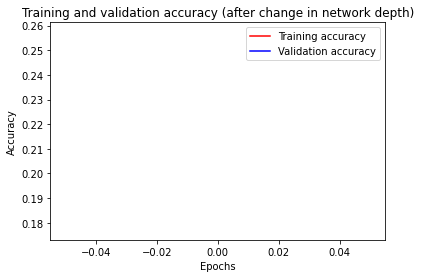

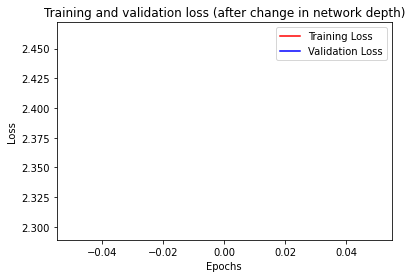

<Figure size 432x288 with 0 Axes>



95/95 [==============================] - 17s 182ms/step - loss: 2.3193 - accuracy: 0.2475
Training accuracy (after change in network depth): 24.75%
Training Loss (after change in network depth):  2.3193070888519287


40/40 [==============================] - 3s 75ms/step - loss: 2.2974 - accuracy: 0.2573
Validation accuracy (after change in network depth): 25.73%
Validation Loss (after change in network depth):  2.297373056411743


In [45]:
# change number of hidden layers and hidden units for each layer

# build model1 - added one hidden layer and changed hidden units for each layer
model1 = tf.keras.models.Sequential([
          # Flatten input
          tf.keras.layers.Flatten(input_shape=(num_img_rows,num_img_cols, num_color_channels)),
          # Layer 1 = input layer with regularization
          tf.keras.layers.Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(num_l2_reg_penalty)),
          # Add dropout
          tf.keras.layers.Dropout(num_dropout),
          # Layer 2 = input layer with regularization
          tf.keras.layers.Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(num_l2_reg_penalty)),
          # Layer 3 = hidden layer with regularization
          tf.keras.layers.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(num_l2_reg_penalty)),
          # Layer 4 = hidden layer with regularization
          tf.keras.layers.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(num_l2_reg_penalty)),
          # Layer 5 = hidden layer with regularization
          tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(num_l2_reg_penalty)),
          # Layer 6 = output layer with regularization
          tf.keras.layers.Dense(10, activation='softmax', kernel_regularizer=tf.keras.regularizers.l2(num_l2_reg_penalty)),
        ])

# compile model1
model1.compile(loss=str_loss,
              optimizer=opt,
              metrics=['accuracy']
             )

# train model1
history1 = model1.fit(
            train_generator,
            epochs=num_epochs,
            steps_per_epoch=num_steps_per_epoch,
            validation_data=val_generator,
            validation_steps=num_val_steps,
            verbose=1,
            callbacks=[timing]
          )

# show model1 summary
model1.summary()

# total training time for model 1
print('\n', 'Total time taken for training (after change in network depth): {:.2f}'.format(sum(timing.logs)), 'seconds', '\n')

acc = history1.history['accuracy']
val_acc = history1.history['val_accuracy']
loss = history1.history['loss']
val_loss = history1.history['val_loss']

epochs = range(len(acc))

# Accuracy history graph for training and validation
plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy (after change in network depth)')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(loc=0)
plt.figure()

# Loss history graph for training and validation
plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss (after change in network depth)')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(loc=0)
plt.figure()

# show plot
plt.show()

# evaluate on train dataset
print('\n')
train1_score = model1.evaluate(train_generator)

# final training accuracy and loss
print("Training accuracy (after change in network depth): {:.2f}%".format(train1_score[1] * 100)) 
print("Training Loss (after change in network depth): ",train1_score[0])

# evaluate on validation dataset
print('\n')
val1_score = model1.evaluate(val_generator)

# final validation accuracy and loss
print("Validation accuracy (after change in network depth): {:.2f}%".format(val1_score[1] * 100)) 
print("Validation Loss (after change in network depth): ",val1_score[0])

95/95 [==============================] - 21s 217ms/step - loss: 2.4687 - accuracy: 0.1465 - val_loss: 2.1890 - val_accuracy: 0.1980
Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_11 (Flatten)         (None, 16875)             0         
_________________________________________________________________
dense_60 (Dense)             (None, 1024)              17281024  
_________________________________________________________________
dense_61 (Dense)             (None, 512)               524800    
_________________________________________________________________
dense_62 (Dense)             (None, 256)               131328    
_________________________________________________________________
dense_63 (Dense)             (None, 128)               32896     
_________________________________________________________________
dense_64 (Dense)             (None, 10)              

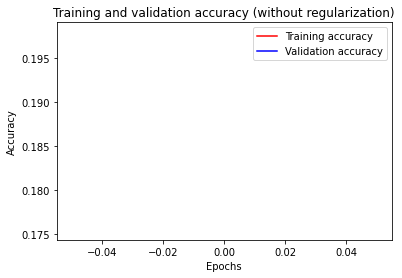

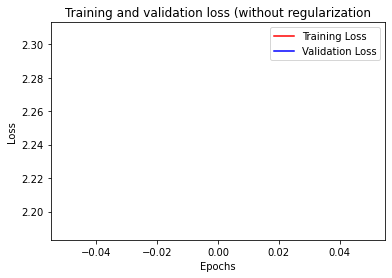

<Figure size 432x288 with 0 Axes>



95/95 [==============================] - 17s 182ms/step - loss: 2.2034 - accuracy: 0.1927
Training accuracy (without regularization): 19.27%
Training Loss (without regularization):  2.203390598297119


40/40 [==============================] - 3s 76ms/step - loss: 2.1890 - accuracy: 0.1980
Validation accuracy (without regularization): 19.80%
Validation Loss (without regularization):  2.189021587371826


In [46]:
# train a model without regularization - kernel & dropout

# build model2
model2 = tf.keras.models.Sequential([
          # Flatten input
          tf.keras.layers.Flatten(input_shape=(num_img_rows,num_img_cols, num_color_channels)),
          # Layer 1 = input layer without regularization
          tf.keras.layers.Dense(1024, activation='relu'),
         # Layer 2 = hidden layer without regularization
          tf.keras.layers.Dense(512, activation='relu'),
          # Layer 3 = hidden layer without regularization
          tf.keras.layers.Dense(256, activation='relu'),
          # Layer 4 = hidden layer without regularization
          tf.keras.layers.Dense(128, activation='relu'),
          # Layer 5 = output layer without regularization
          tf.keras.layers.Dense(10, activation='softmax'),
        ])

# compile model2
model2.compile(loss=str_loss,
              optimizer=opt,
              metrics=['accuracy']
             )

# train model2
history2 = model2.fit(
            train_generator,
            epochs=num_epochs,
            steps_per_epoch=num_steps_per_epoch,
            validation_data=val_generator,
            validation_steps=num_val_steps,
            verbose=1,
            callbacks=[timing]
          )

# show model2 summary
model2.summary()

# total training time for model 2
print('\n', 'Total time taken for training (without regularization): {:.2f}'.format(sum(timing.logs)), 'seconds', '\n')

acc = history2.history['accuracy']
val_acc = history2.history['val_accuracy']
loss = history2.history['loss']
val_loss = history2.history['val_loss']

epochs = range(len(acc))

# Accuracy history graph for training and validation
plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy (without regularization)')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(loc=0)
plt.figure()

# Loss history graph for training and validation
plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss (without regularization')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(loc=0)
plt.figure()

# show plot
plt.show()

# evaluate on train dataset
print('\n')
train2_score = model2.evaluate(train_generator)

# final training accuracy and loss
print("Training accuracy (without regularization): {:.2f}%".format(train2_score[1] * 100)) 
print("Training Loss (without regularization): ",train2_score[0])

# evaluate on validation dataset
print('\n')
val2_score = model2.evaluate(val_generator)

# final validation accuracy and loss
print("Validation accuracy (without regularization): {:.2f}%".format(val2_score[1] * 100)) 
print("Validation Loss (without regularization): ",val2_score[0])